# Extract Shadow and Sun Masks from Near-IR

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mrahnis/nb-vegetation/blob/main/Step-02-Veggie-Shadows.ipynb)

In [1]:
# if the notebook is running in colab we'll get the data from github
HOST_IS_COLAB = 'google.colab' in str(get_ipython())

if HOST_IS_COLAB:
    # if using the regular Colab runtime install rasterio and others packages
    !pip install rasterio --quiet --exists-action i
    !pip install fiona --quiet --exists-action i
    !pip install shapely --quiet --exists-action i
    path = 'https://github.com/mrahnis/nb-vegetation/blob/main'
    params = '?raw=true'
    !mkdir results
else:
    path = '.'
    params = ''

In [2]:
import timeit
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import colormaps
from matplotlib.patches import Patch, Rectangle
import fiona
import shapely
import rasterio
from rasterio.windows import from_bounds
from rasterio.features import shapes
from skimage import segmentation, feature, future, morphology
from skimage.exposure import histogram
from skimage.filters import rank, apply_hysteresis_threshold
from skimage.color import rgb2lab, lab2rgb, rgb2hsv
from sklearn.ensemble import RandomForestClassifier

In [3]:
"""Load RGB+NIR TIFF data"""
image_file = '{}/data/pa_greatmarsh_2022_naip.tif{}'.format(path, params)
src = rasterio.open(image_file)

# read band data
rgb = src.read()

# switch from band-first raster to band-last image to display later
img = np.moveaxis(src.read(), 0, 2)

## Make a simple mask

The shadows show up clearly in the Near-IR band. Let's try thresholding that to make a mask.

Text(0, 0.5, 'pixels')

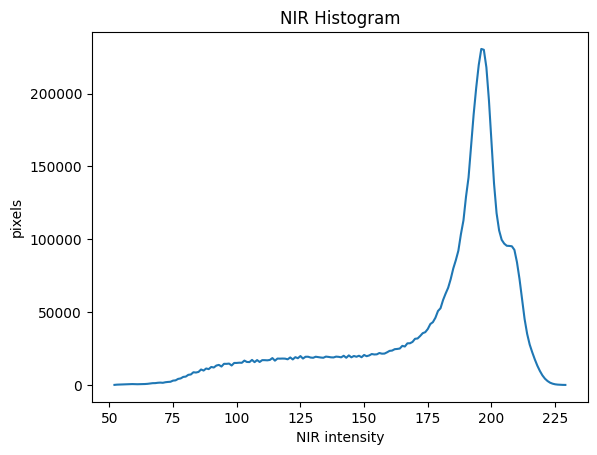

In [4]:
fig, ax = plt.subplots(1, 1)

V_hist, V_centers = histogram(rgb[3,:,:], nbins=256)
ax.plot(V_centers, V_hist)
ax.set_title("NIR Histogram")
ax.set_xlabel('NIR intensity')
ax.set_ylabel('pixels')

### Make shade and water pixel masks

The shade pixels are in the left tail of the distribution, and have values less than about 130 in the umbra up to about 160 in the penumbra. We can use hysteresis thresholding to try to capture the umbra and penumbra together. The lowest intensity values belong to water pixels and have values less than about 63 up to about 80.

In [5]:
# the shade pixels are True and sunlight pixels are False
# shade = (rgb[3,:,:] > 75) & (rgb[3,:,:] < 110)
_shade = ~apply_hysteresis_threshold(rgb[3,:,:], 130, 160)
water = apply_hysteresis_threshold(1./rgb[3,:,:], 1./80., 1./63.)
shade = morphology.binary_closing((_shade & ~water), morphology.disk(2, dtype=bool))

### Make sunlit mask for pixels adjacent to shade pixels

In this image the sun was coming up in the East and casts shadows toward the West. We can take the shade mask we have and roll it in the West direction to try to capture sunlit pixels near to the shaded ones.

In [6]:
_sunlit = np.zeros_like(shade)

# roll west, south, north to capture the shadow direction
for i in np.arange(1, 9):
    _sunlit += (np.roll(shade, -i, axis=1))

_sunlit += np.roll(_sunlit, 1, axis=0)
_sunlit += np.roll(_sunlit, -1, axis=0)

sunlit = (_sunlit & ~shade & ~(rgb[3,:,:] < 120))

In [7]:
print(f'shade pixels: {np.count_nonzero(shade)}')
print(f'sunlit pixels: {np.count_nonzero(sunlit)}')

shade pixels: 858818
sunlit pixels: 747062


### Show the pixel masks

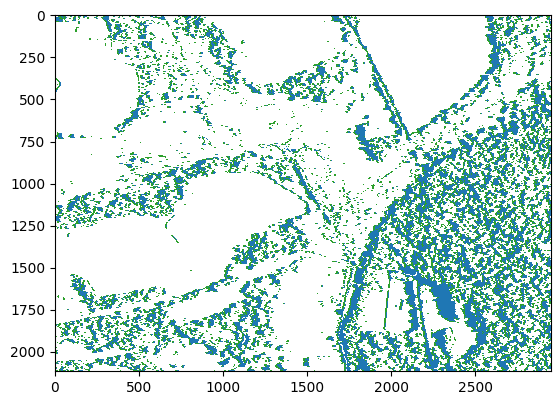

In [8]:
masks = np.zeros_like(shade)
masks = np.where(sunlit, 2, shade)

# 0 = unsampled, 1 = shade, 2 = sunlit
tab10 = colormaps['tab10']
cmap = colors.ListedColormap(["white", tab10(0.0), tab10(0.2)])

fig, ax = plt.subplots(1, 1)
ax.imshow(masks, cmap=cmap, interpolation='none')

plt.show()

## Make a shadow probability map

We can make a bit more sophisticated shadow map using the NIR band and measures of Luminosity by transforming the visible RGB band data.

L\*a\*b\* Colorspace
Our Great Marsh wetland scene is dominated by green vegetation during growing season. Much of the variability is in qualities of saturation and luminosity of these greens. We can experiment with colorspaces other than RGB to see this.

L*: 18.070250083789134 85.07333989734613
a*: -23.007173550230327 37.3243772124851
b*: -29.557203887911232 53.61314610231875


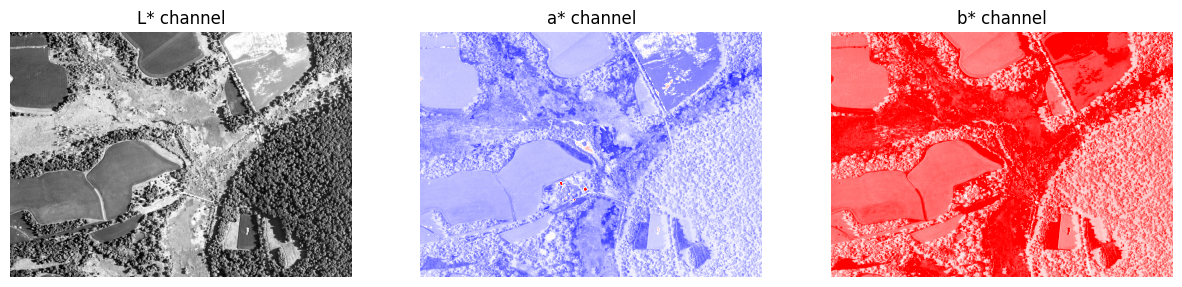

In [9]:
from skimage.color import rgb2lab
from skimage.exposure import histogram, adjust_gamma, adjust_sigmoid, rescale_intensity, equalize_hist

lab = rgb2lab(img[:,:,:3])

L_star = lab[:,:,0]
a_star = lab[:,:,1]
b_star = lab[:,:,2]
print('L*:', L_star.min(), L_star.max())
print('a*:', a_star.min(), a_star.max())
print('b*:', b_star.min(), b_star.max())

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15, 8), sharex=True, sharey=True)

# ax2.imshow(adjust_gamma(L_star, gamma=1.6), cmap='gray', norm='linear')
ax0.imshow(equalize_hist(L_star), cmap='gray')
ax0.set_title("L* channel")
ax0.axis('off')
ax1.imshow(a_star, cmap='bwr', vmin=-20, vmax=20)
ax1.set_title("a* channel")
ax1.axis('off')
ax2.imshow(b_star, cmap='bwr', vmin=-20, vmax=20)
ax2.set_title("b* channel")
ax2.axis('off')

plt.show()

In [10]:
dark_nir = 1 - img[:,:,3] / 255
dark_vis = 1 - L_star / 100

print('Dark NIR:', dark_nir.min(), dark_nir.max())
print('Dark Visible (L*):', dark_vis.min(), dark_vis.max())

Dark NIR: 0.10196078431372546 0.7960784313725491
Dark Visible (L*): 0.14926660102653866 0.8192974991621087


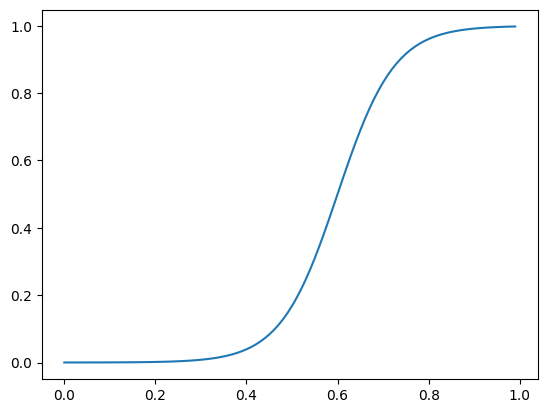

In [11]:
def position(arr, k=4.0, x0=0.5):
    '''
    where
    k is the maximum slope of the logistic curve and
    x0 is the midpoint of the logistic curve
    '''
    x = k*(arr-x0)
    result = 1. / (1. + np.exp(-x))
    return result


lx = np.arange(0,1,0.01)
ly = position(lx, k=16, x0=0.6)

fig, ax0 = plt.subplots(ncols=1)
ax0.plot(lx,ly)

plt.show()

In [12]:
dark_map = position(dark_nir, k=24, x0=0.5) * position(dark_vis, k=24, x0=0.5)

print(dark_map.min(), dark_map.max())

4.912951919284211e-08 0.998311461648251


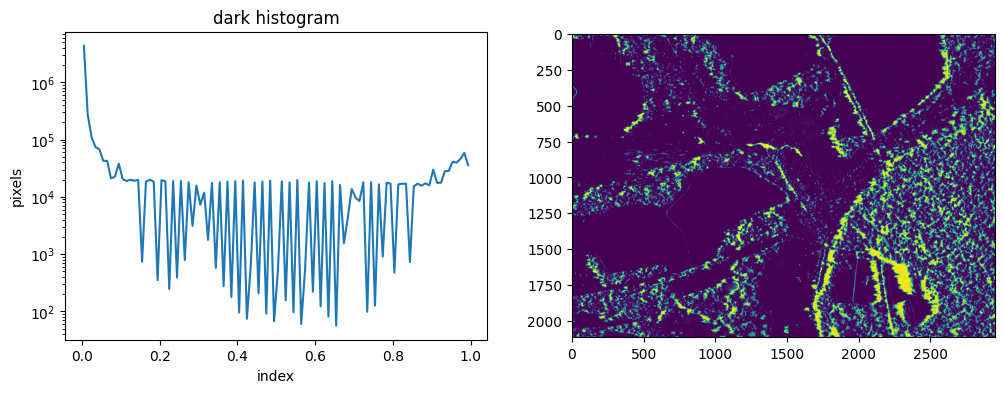

In [13]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12,4))

dark_hist, dark_centers = histogram(dark_map, nbins=100)
ax0.plot(dark_centers, dark_hist)
ax0.set_yscale('log')
ax0.set_title("dark histogram")
ax0.set_xlabel('index')
ax0.set_ylabel('pixels')
ax1.imshow(dark_map)
plt.show()

### Remove water from the dark map

The dark map above still includes water so we will want to set those pixels to zero. We can use the water mask we calculated previously, however, there may be room for improvement.

In [14]:
dark_map = np.where(~water, dark_map, 0)

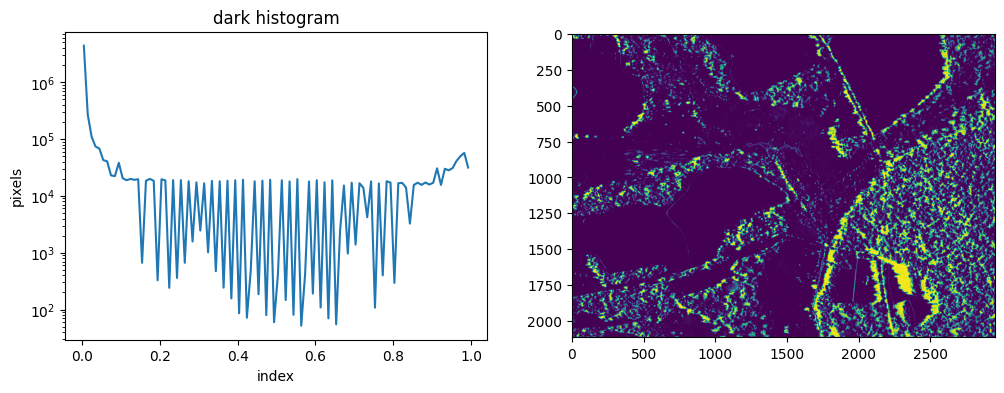

In [15]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12,4))

dark_hist, dark_centers = histogram(dark_map, nbins=100)
ax0.plot(dark_centers, dark_hist)
ax0.set_yscale('log')
ax0.set_title("dark histogram")
ax0.set_xlabel('index')
ax0.set_ylabel('pixels')
ax1.imshow(dark_map)
plt.show()

### [TODO] Make a new histogram 
- threshold the shadows by P dark index
- histogram with L* on the bottom and curve for count of shadow and count of sunlit

In [16]:
# Write out the shadow mask and sun mask
out_shade = './results/shadow_mask.tif'
out_sun = './results/sunlit_mask.tif'
out_dark = './results/dark_mask.tif'

with rasterio.open(
    out_shade,
    'w',
    driver='GTiff',
    height=shade.shape[0],
    width=shade.shape[1],
    count=1,
    dtype=np.uint8,
    crs=src.crs,
    transform=src.transform,
) as dst:
    dst.write(shade, 1)
    
with rasterio.open(
    out_sun,
    'w',
    driver='GTiff',
    height=sunlit.shape[0],
    width=sunlit.shape[1],
    count=1,
    dtype=np.uint8,
    crs=src.crs,
    transform=src.transform,
) as dst:
    dst.write(sunlit, 1)

with rasterio.open(
    out_dark,
    'w',
    driver='GTiff',
    height=dark_map.shape[0],
    width=dark_map.shape[1],
    count=1,
    dtype=np.float32,
    crs=src.crs,
    transform=src.transform,
) as dst:
    dst.write(dark_map, 1)

src.close()

## Reading

Removing Shadows from Images Using Color and Near-Infrared\
https://projet.liris.cnrs.fr/imagine/pub/proceedings/ICIP-2011/papers/1569408413.pdf

Illuminant estimation and detection using near-infrared\
https://ivrlwww.epfl.ch/alumni/fredemba/papers/FS_EI09.pdf